# Human Emotions Detection

Dataset: https://www.kaggle.com/datasets/muhammadhananasghar/human-emotions-datasethes

This notebook use the `EmotionsDataset_Splitted` folder which contains 4 classes (`angry`, `happy`, `nothing`, `sad`) and train a model to classify images to those 4 classes

## Import Libraries

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import datetime

In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import TopKCategoricalAccuracy, CategoricalAccuracy, Accuracy
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
tf.__version__

'2.12.0'

## Data Preparation

### Download Dataset

In [ ]:
!pip install -q kaggle

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d muhammadhananasghar/human-emotions-datasethes

100% 308M/309M [00:01<00:00, 204MB/s]
100% 309M/309M [00:01<00:00, 239MB/s]


In [ ]:
!unzip "/content/human-emotions-datasethes.zip" -d "/content/dataset/"

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/EmotionsDataset/data/nothing/720.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/721.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/722.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/723.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/724.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/725.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/726.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/727.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/728.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/729.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/73.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/730.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/731.jpg  
  inflating: /content/dataset/EmotionsDataset/data/no

In [ ]:
# train_dir = './dataset/Emotions Dataset/Emotions Dataset/train/'
# val_dir = './dataset/Emotions Dataset/Emotions Dataset/test/'

train_dir = './dataset/EmotionsDataset_Splitted/data/train/'
val_dir = './dataset/EmotionsDataset_Splitted/data/test/'

## Sample Visualization

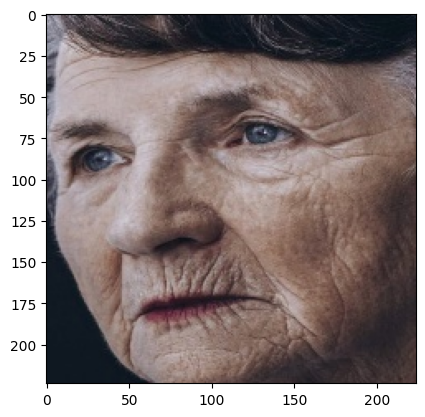

In [ ]:
# plt.imshow(image.load_img('./dataset/Emotions Dataset/Emotions Dataset/train/sad/102961.jpg'))
plt.imshow(image.load_img('./dataset/EmotionsDataset_Splitted/data/train/sad/93.jpg'))
plt.show()

## Data Preprocessing

In [ ]:
# All images will be rescaled by 1./255
train_original_datagen = ImageDataGenerator(rescale=1./255)

train_augmented_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    horizontal_flip=True,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    brightness_range=(0.7, 1.3)
)

validation_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 128 using train_datagen generator
train_original_generator = train_original_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(224, 224),  # All images will be resized to 224x224
        batch_size=32,
        shuffle=True,
        class_mode='sparse',
        keep_aspect_ratio=True,
        seed=43)

# # Flow training images in batches of 128 using train_datagen generator
# train_augmented_generator = train_augmented_datagen.flow_from_directory(
#         train_dir,  # This is the source directory for training images
#         target_size=(224, 224),  # All images will be resized to 224x224
#         batch_size=32,
#         shuffle=True,
#         class_mode='sparse',
#         keep_aspect_ratio=True,
#         seed=43)

# Flow validation images in batches of 128 using validation_datagen generator
validation_generator = validation_datagen.flow_from_directory(
        val_dir,  # This is the source directory for validation images
        target_size=(224, 224),  # All images will be resized to 224x224
        batch_size=8,
        keep_aspect_ratio=True,
        class_mode='sparse')

Found 3152 images belonging to 4 classes.
Found 3152 images belonging to 4 classes.
Found 788 images belonging to 4 classes.


In [ ]:
# # Combine original and augmented generators
# def combined_generator(original_gen, augmented_gen):
#     while True:
#         batch_original = next(original_gen)
#         batch_augmented = next(augmented_gen)
#         combined_images = np.vstack((batch_original[0], batch_augmented[0]))
#         combined_labels = np.vstack((batch_original[1], batch_augmented[1]))
#         yield combined_images, combined_labels

In [ ]:
# train_generator = combined_generator(train_original_generator, train_augmented_generator)

In [ ]:
for batch_images, batch_labels in train_original_generator:
    print(batch_images.shape)
    print(batch_labels.shape)
    break

(32, 224, 224, 3)
(32,)


## Class weights

In [ ]:
# Get the unique class labels
unique_labels = np.unique(train_original_generator.classes)

# Calculate class weights using the compute_class_weight function
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=unique_labels,
    y=train_original_generator.classes
)

# Convert the class weights to a dictionary format
class_weight_dict = {label: weight for label, weight in zip(unique_labels, class_weights)}
class_weight_dict

{0: 0.9270588235294117,
 1: 0.9493975903614458,
 2: 0.9016018306636155,
 3: 1.3177257525083612}

## Model Training

### Tensorboard

In [ ]:
pip install -U tensorboard_plugin_profile

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 15.3 MB/s eta 0:00:00


In [ ]:
!rm -rf ./logs/

In [ ]:
CURRENT_TIME = datetime.datetime.now().strftime('%d%m%y - %h%m%s')
METRIC_DIR = './logs/' + CURRENT_TIME + '/metrics'
train_writer = tf.summary.create_file_writer(METRIC_DIR)

In [ ]:
LOG_DIR = './logs/'+ CURRENT_TIME
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=LOG_DIR, histogram_freq = 1, profile_batch = '100,132')

## Pre Trained Model

### Use MobileNet

Since the model built will be used on application and needs to give prediction fast, we choose the `MobileNet` pretrained model that well known for fast prediction while maintaining the performance

In [ ]:
# Load MobileNetV2 with pre-trained weights from ImageNet
backbone = tf.keras.applications.mobilenet_v2.MobileNetV2(
    include_top = False,
    weights='imagenet',
    input_shape=(224, 224, 3),
    )

We use fine-tunning the pre trained model

In [ ]:
# backbone.trainable = False

### Training

In [ ]:
n_class = train_original_generator.num_classes
n_class

4

Since we use sparse `ImageDataGenerator`, we use `SparseCategoricalAccuracy` for the metrics

In [ ]:
metrics = [tf.keras.metrics.SparseCategoricalAccuracy(name = 'accuracy')]

In [ ]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    'best_weights',
    monitor='val_accuracy',
    mode = 'max',
    verbose=1,
    save_best_only=True,
    )

In [ ]:
# Define callbacks
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3, min_lr=1e-8, verbose=1)
early_stop = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True, verbose=1)

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(224, 224, 3)),
    backbone,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(n_class, activation='softmax')
])

In [ ]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(learning_rate = 1e-4),
              metrics=metrics
              )

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              1311744   
                                                                 
 batch_normalization (BatchN  (None, 1024)             4096      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 128)               131200    
                                                        

In [ ]:
history = model.fit(
      train_original_generator,
      epochs=20,
      validation_data = validation_generator,
      callbacks=[tensorboard_callback, checkpoint_callback, reduce_lr, early_stop],
      class_weight=class_weight_dict,
      )

Epoch 1/20
99/99 [==============================] - ETA: 0s - loss: 0.8272 - accuracy: 0.6739
Epoch 1: val_accuracy improved from -inf to 0.62563, saving model to best_weights


99/99 [==============================] - 101s 466ms/step - loss: 0.8272 - accuracy: 0.6739 - val_loss: 0.7988 - val_accuracy: 0.6256 - lr: 1.0000e-04
Epoch 2/20
99/99 [==============================] - ETA: 0s - loss: 0.4483 - accuracy: 0.8287
Epoch 2: val_accuracy improved from 0.62563 to 0.68401, saving model to best_weights


99/99 [==============================] - 47s 474ms/step - loss: 0.4483 - accuracy: 0.8287 - val_loss: 0.7163 - val_accuracy: 0.6840 - lr: 1.0000e-04
Epoch 3/20
99/99 [==============================] - ETA: 0s - loss: 0.3440 - accuracy: 0.8671
Epoch 3: val_accuracy improved from 0.68401 to 0.70939, saving model to best_weights


99/99 [==============================] - 42s 430ms/step - loss: 0.3440 - accuracy: 0.8671 - val_loss: 0.6648 - val_accuracy: 0.7094 - lr: 1.0000e-04
Epoch 4/20
99/99 [==============================] - ETA: 0s - loss: 0.2971 - accuracy: 0.8877
Epoch 4: val_accuracy improved from 0.70939 to 0.72716, saving model to best_weights


99/99 [==============================] - 43s 438ms/step - loss: 0.2971 - accuracy: 0.8877 - val_loss: 0.7018 - val_accuracy: 0.7272 - lr: 1.0000e-04
Epoch 5/20
99/99 [==============================] - ETA: 0s - loss: 0.2698 - accuracy: 0.8947
Epoch 5: val_accuracy improved from 0.72716 to 0.73985, saving model to best_weights


99/99 [==============================] - 43s 435ms/step - loss: 0.2698 - accuracy: 0.8947 - val_loss: 0.6655 - val_accuracy: 0.7398 - lr: 1.0000e-04
Epoch 6/20
99/99 [==============================] - ETA: 0s - loss: 0.2549 - accuracy: 0.8985
Epoch 6: val_accuracy did not improve from 0.73985

Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
99/99 [==============================] - 18s 185ms/step - loss: 0.2549 - accuracy: 0.8985 - val_loss: 0.6999 - val_accuracy: 0.7246 - lr: 1.0000e-04
Epoch 7/20
99/99 [==============================] - ETA: 0s - loss: 0.2094 - accuracy: 0.9156
Epoch 7: val_accuracy improved from 0.73985 to 0.75508, saving model to best_weights


99/99 [==============================] - 43s 432ms/step - loss: 0.2094 - accuracy: 0.9156 - val_loss: 0.6654 - val_accuracy: 0.7551 - lr: 5.0000e-05
Epoch 8/20
99/99 [==============================] - ETA: 0s - loss: 0.1901 - accuracy: 0.9140
Epoch 8: val_accuracy improved from 0.75508 to 0.77538, saving model to best_weights


99/99 [==============================] - 42s 430ms/step - loss: 0.1901 - accuracy: 0.9140 - val_loss: 0.6515 - val_accuracy: 0.7754 - lr: 5.0000e-05
Epoch 9/20
99/99 [==============================] - ETA: 0s - loss: 0.1829 - accuracy: 0.9143
Epoch 9: val_accuracy did not improve from 0.77538
99/99 [==============================] - 18s 179ms/step - loss: 0.1829 - accuracy: 0.9143 - val_loss: 0.6755 - val_accuracy: 0.7627 - lr: 5.0000e-05
Epoch 10/20
99/99 [==============================] - ETA: 0s - loss: 0.1814 - accuracy: 0.9134
Epoch 10: val_accuracy did not improve from 0.77538
99/99 [==============================] - 17s 173ms/step - loss: 0.1814 - accuracy: 0.9134 - val_loss: 0.7166 - val_accuracy: 0.7652 - lr: 5.0000e-05
Epoch 11/20
99/99 [==============================] - ETA: 0s - loss: 0.1726 - accuracy: 0.9112
Epoch 11: val_accuracy did not improve from 0.77538

Epoch 11: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
99/99 [=============================

## Evaluation

In [ ]:
model.load_weights('best_weights')

In [ ]:
# model = tf.keras.models.load_model('human_emotions_detection_mobilenet5.h5')

In [ ]:
model.evaluate(validation_generator)

Exception ignored in: <function _xla_gc_callback at 0x7f7a4bf016c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 98, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


99/99 [==============================] - 2s 17ms/step - loss: 0.6515 - accuracy: 0.7754


[0.651469886302948, 0.7753807306289673]

### Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
# Initialize empty arrays to accumulate predictions and true labels
all_predictions = []
all_true_labels = []

# Iterate through the validation generator
for batch_images, batch_labels in validation_generator:
    # Predict using your model
    batch_predictions = model.predict(batch_images)

    # Accumulate batch predictions and true labels
    all_predictions.extend(np.argmax(batch_predictions, axis = 1))
    all_true_labels.extend(batch_labels)

    # Check if you've processed all validation samples
    if len(all_predictions) >= len(validation_generator) * 8: # default batch_size = 32 if not specified from ImageDataGenerator.flow_from_directory on validation
        break

# Convert accumulated lists to numpy arrays
all_predictions = np.array(all_predictions)
all_true_labels = np.array(all_true_labels)

1/1 [==============================] - 0s 26ms/step


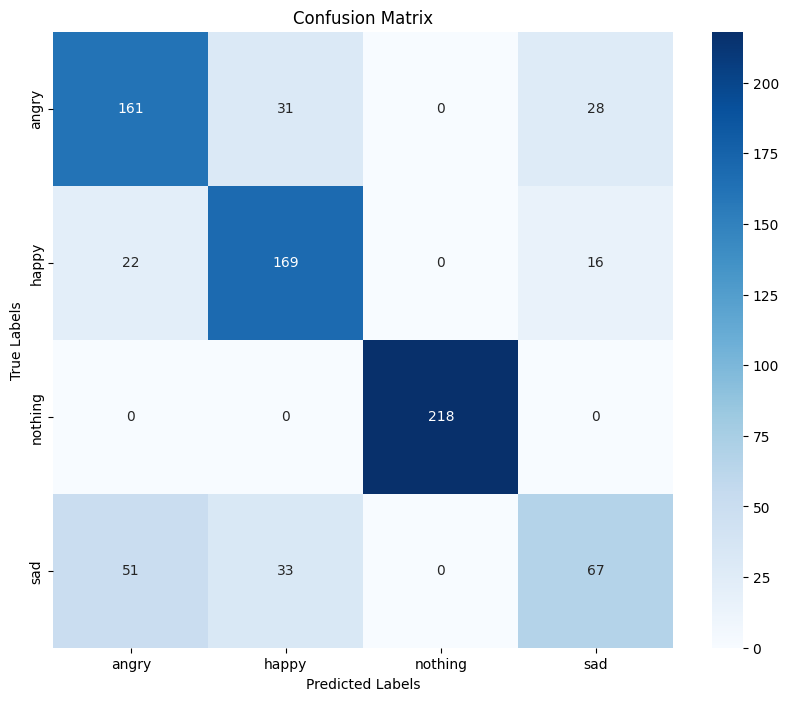

In [ ]:
# Assuming you have predicted labels and true labels
y_pred = all_predictions.copy()
y_true = all_true_labels.copy()

# Create the confusion matrix
confusion_mat = confusion_matrix(y_true, y_pred)

# Get the unique class labels
class_labels = sorted(validation_generator.class_indices.keys())

# Create a heatmap using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
import cv2

test_image = cv2.imread('./dataset/EmotionsDataset_Splitted/data/test/happy/1.jpg')
test_image = cv2.resize(test_image, (224, 224))
im = tf.constant(test_image, dtype = tf.float32)

im = tf.expand_dims(im, axis = 0)
print(model(im))
print(["angry", "happy", "nothing", "sad"][tf.argmax(model(im), axis = -1).numpy()[0]])

tf.Tensor([[1.4044874e-04 7.3065376e-01 2.6919270e-01 1.3165149e-05]], shape=(1, 4), dtype=float32)
happy


### Tensorboard

In [ ]:
%load_ext tensorboard

In [ ]:
# !kill 8991

In [ ]:
tensorboard --logdir='./logs'

## Save Model

In [ ]:
model.save('human_emotions_detection_mobilenet5.h5')